C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Top 10 Most Important Features (Random Forest):
                            Feature  Importance
33                         Schiller    0.292293
32                       Hinselmann    0.101118
0                               Age    0.096296
2          First sexual intercourse    0.084431
8   Hormonal Contraceptives (years)    0.066418
34                         Citology    0.053859
1         Number of sexual partners    0.052981
3                Num of pregnancies    0.052951
5                    Smokes (years)    0.023247
10                      IUD (years)    0.019222

Top 10 Features by Correlation with Cancer:
                Feature  Correlation
33             Schiller     0.733204
32           Hinselmann     0.547417
34             Citology     0.327466
28            Dx:Cancer     0.160905
30               Dx:HPV     0.160905
31                   Dx     0.157607
19  STDs:genital herpes     0.130523
22             STDs:HIV     0.127702
11                 STDs     0.114148
29      

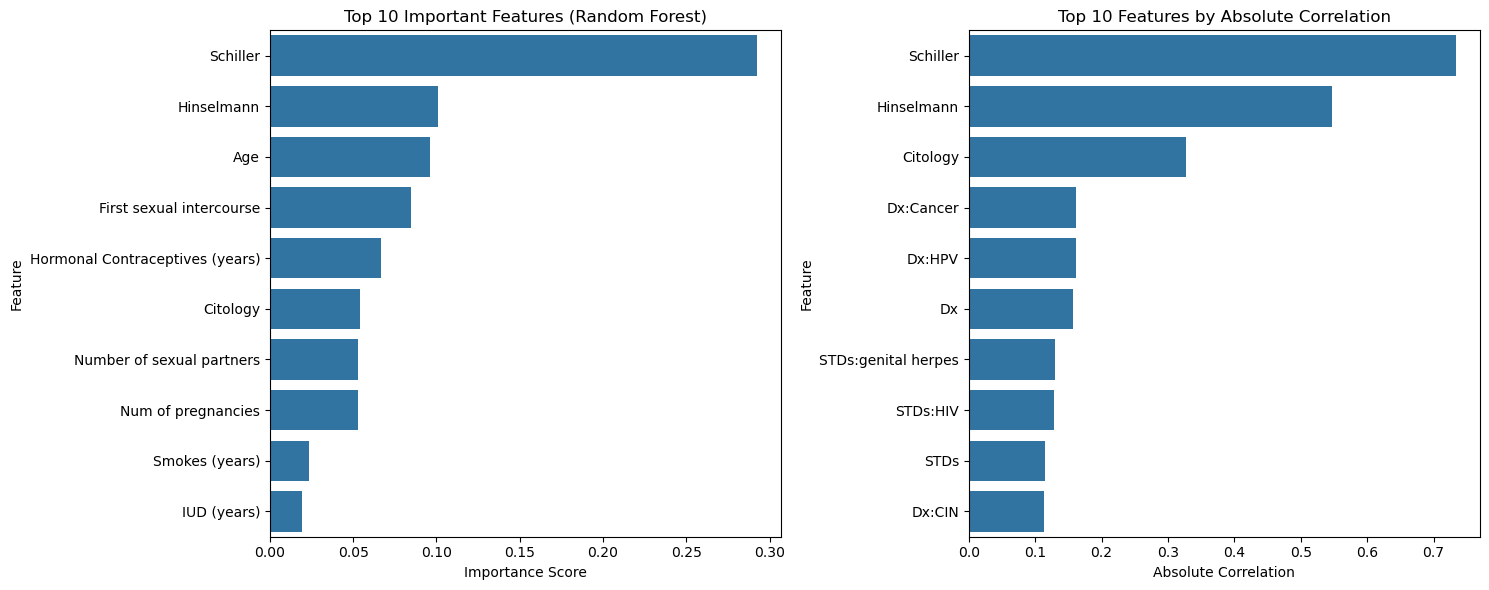

<Figure size 1000x800 with 0 Axes>

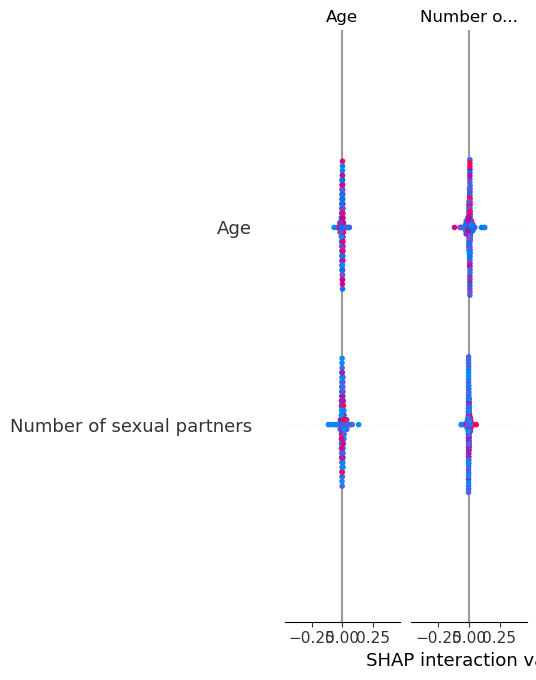

<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

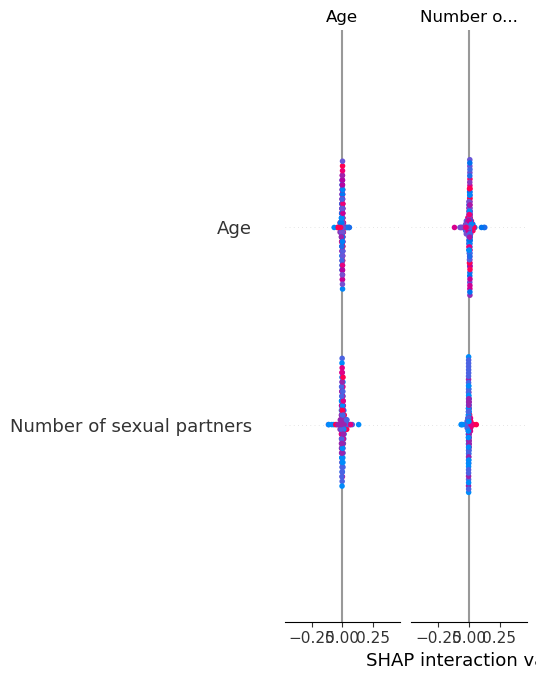

<Figure size 640x480 with 0 Axes>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data(file_path):
    """
    Load and preprocess the cervical cancer dataset
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Replace '?' with NaN (if any exist in the dataset)
    df = df.replace('?', np.nan)
    
    # Convert all columns to numeric
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    
    # Handle missing values
    df = df.fillna(df.median())
    
    return df

def analyze_feature_importance(df):
    """
    Analyze feature importance using multiple methods
    """
    # Prepare features and target
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert scaled arrays back to DataFrames to preserve column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
    
    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    
    # Get feature importance scores
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Calculate correlations with target
    correlations = pd.DataFrame({
        'Feature': X.columns,
        'Correlation': [df[col].corr(df['Biopsy']) for col in X.columns]
    }).sort_values('Correlation', ascending=False)
    
    return importance_df, correlations, rf_model, X_test_scaled

def plot_feature_importance(importance_df, correlations):
    """
    Create visualizations for feature importance
    """
    # Plot Random Forest feature importance
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title('Top 10 Important Features (Random Forest)')
    plt.xlabel('Importance Score')
    
    # Plot absolute correlations
    plt.subplot(1, 2, 2)
    correlations['Abs_Correlation'] = abs(correlations['Correlation'])
    correlations = correlations.sort_values('Abs_Correlation', ascending=False)
    sns.barplot(x='Abs_Correlation', y='Feature', data=correlations.head(10))
    plt.title('Top 10 Features by Absolute Correlation')
    plt.xlabel('Absolute Correlation')
    
    plt.tight_layout()
    plt.show()

def plot_shap_values(model, X_test_scaled):
    """
    Create SHAP value plots
    """
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_scaled)
    
    # If shap_values is a list (for binary classification), take the first element
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Using class 1 (positive class) SHAP values
    
    # Create SHAP summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")
    plt.tight_layout()
    
    # Create SHAP beeswarm plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_scaled)
    plt.tight_layout()

# Main execution
if __name__ == "__main__":
    # Load and preprocess the data
    file_path = r"D:\CC 36\kag_risk_factors_cervical_cancer.csv"
    df = load_and_preprocess_data(file_path)
    
    # Analyze feature importance
    importance_df, correlations, model, X_test_scaled = analyze_feature_importance(df)
    
    # Print top 10 most important features
    print("\nTop 10 Most Important Features (Random Forest):")
    print(importance_df.head(10))
    
    print("\nTop 10 Features by Correlation with Cancer:")
    print(correlations.head(10))
    
    # Create visualizations
    plot_feature_importance(importance_df, correlations)
    plot_shap_values(model, X_test_scaled)